In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/aslr_model.hdf5'
tflite_save_path = 'model/aslr_model.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 24

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
131/141 [==========================>...] - ETA: 0s - loss: 3.0722 - accuracy: 0.0921
Epoch 1: saving model to model\aslr_model.hdf5
141/141 [==============================] - 1s 4ms/step - loss: 3.0576 - accuracy: 0.0969 - val_loss: 2.7637 - val_accuracy: 0.2067
Epoch 2/1000
137/141 [============================>.] - ETA: 0s - loss: 2.5623 - accuracy: 0.2088
Epoch 2: saving model to model\aslr_model.hdf5
141/141 [==============================] - 0s 2ms/step - loss: 2.5544 - accuracy: 0.2107 - val_loss: 2.1140 - val_accuracy: 0.4452
Epoch 3/1000
137/141 [============================>.] - ETA: 0s - loss: 2.1680 - accuracy: 0.2867
Epoch 3: saving model to model\aslr_model.hdf5
141/141 [==============================] - 0s 2ms/step - loss: 2.1648 - accuracy: 0.2870 - val_loss: 1.6959 - val_accuracy: 0.5480
Epoch 4/1000
137/141 [============================>.] - ETA: 0s - loss: 1.9568 - accuracy: 0.3249
Epoch 4: saving model to model\aslr_model.hdf5
141/141 [==================

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

47/47 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.9020


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 83ms/step
[9.28988792e-24 3.51991423e-17 3.66552873e-15 2.09119802e-19
 0.00000000e+00 4.51181108e-29 6.66217029e-01 3.33782494e-01
 4.38757271e-27 0.00000000e+00 1.95950818e-25 0.00000000e+00
 0.00000000e+00 4.25115703e-18 9.70987242e-23 1.67605404e-20
 4.52224990e-23 3.42541640e-31 3.77484184e-07 1.47823105e-22
 0.00000000e+00 0.00000000e+00 2.55595456e-09 1.17835816e-17]
6


# Confusion matrix

In [15]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)


188/188 [==============================] - 0s 834us/step


188/188 [==============================] - 0s 698us/step


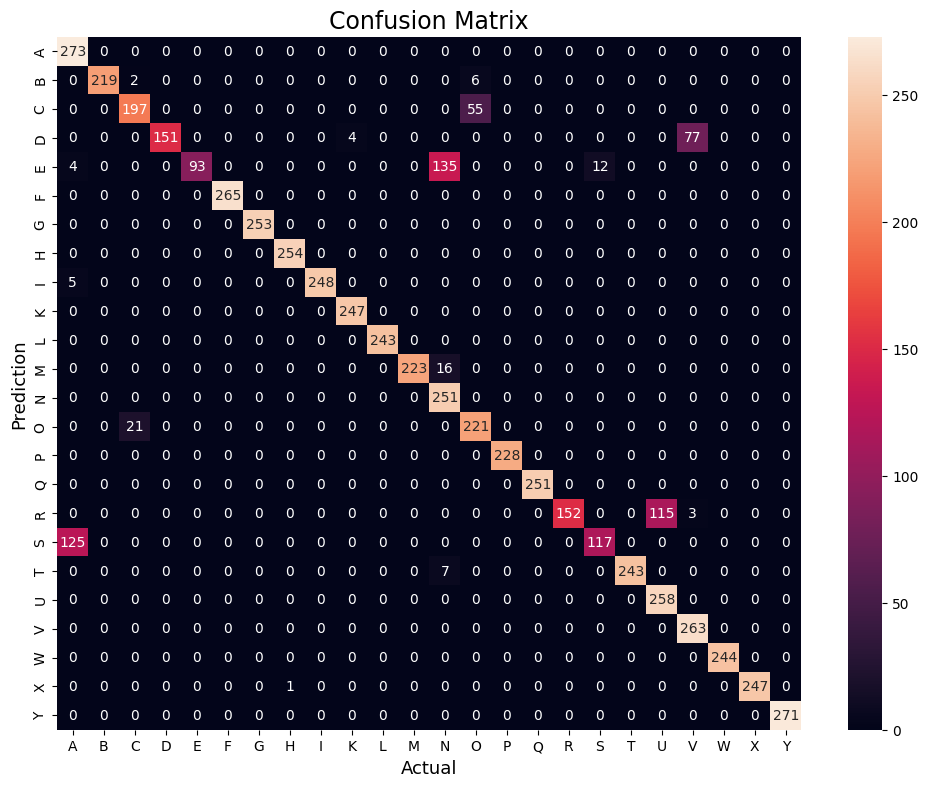

Accuracy   : 0.902


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
prediction = model.predict(X_test)
y_pred = np.argmax(prediction, axis=1)


cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix.
plt.subplots(figsize=(12, 9))

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix',fontsize=17)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)


# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\amurm\AppData\Local\Temp\tmpgqghto_f\assets


INFO:tensorflow:Assets written to: C:\Users\amurm\AppData\Local\Temp\tmpgqghto_f\assets


7424